# Анализ активности пользователей-авторов, а также процедуры голосования на портале Wikipedia
---

## Цели и задачи исследования

В нашем распоряжении находятся  данные об активности пользователей-авторов Wikipedia за 2007 - 2023 годы (датасет stats), а также данные о процедуре голосования за авторов портала Wikipedia за период 2008 - 2023 годы (датасет votes).

В данной работе мы проведём анализ активности пользователей, сделаем сегментацию. Также проанализируем динамику голосований в различной разбивке, попробуем выявить интересные неявные закономерности.

Цель проекта:

    - Изучить данные, привести их в пригодный для анализа формат.
    - Найти закономерности / особенности в голосовании пользователей.

Задачи:

- выполнить предобработку данных (откорректировать форматы, устранить пропуски, обнаружить и устранить аномалии, дубликаты и т.д.);
- проанализировать активность пользователей по датасету stats, построить визуализации;
- исследовать голосующую аудиторию проекта, выбрать параметры для сегментации, разделить пользователей на сегменты и изучить данные подробнее в разрезе сегментов, построить визуализации.
- сформулировать выводы по результатам проведенной работы.

**Описание датасетов.**

stats — информация о пользователях:

    - Edits - Количество правок
    - Reverts - Количество отмен чужих прав
    - Log - Количество иных действий
    - Diff - Добавленное минус удалённое
    - Volume - Общий объём добавленного
    - Tot size - Накопленная сумма добавленного
    - Time - Время онлайн
    - Speed - Скорость (количество правок в единицу времени)
    - User - Ник пользователя
    - txt - Дата в текстовом формате

votes — информация о голосовании:

    - voter - Голосующий
    - can_vote - Проходит по критериям
    - time - Время голоса
    - candidate - Кандидат, по которому голос
    - n - Номер выборов, с дробными частями - довыборы
    - vote - Голос, 1 - за, -1 - против
    - lt - Суток от начала текущих выборов

Сперва импортируем библиотеки, необходимые нам для работы.

In [51]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import scipy.stats as st
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Загрузим датасеты и познакомимся с ними.

In [52]:
try:
    stats = pd.read_excel('/datasets/stats.xlsx')
except:
    stats = pd.read_excel('C:/Users/sutul/datasets/wikipedia/stats.xlsx')

In [53]:
stats.head()

,Edits,Reverts,Log,Diff,Volume,Tot size,Time,Speed,User,txt
0,1589,NaN,1621.0,262 k,1.1 M,39 M,95 h,34/h,Altes,200708
1,1809,NaN,1328.0,395 k,2.8 M,42 M,129 h,24/h,Obersachse,200708
2,2734,NaN,NaN,16 k,15 k,19 M,105 h,26/h,Monegasque~ruwiki,200708
3,2611,NaN,6.0,278 k,350 k,43 M,135 h,19/h,User№101,200708
4,917,6.0,1416.0,154 k,1.2 M,26 M,98 h,24/h,Kalan,200708


In [54]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28950 entries, 0 to 28949
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Edits     28950 non-null  int64  
 1   Reverts   10157 non-null  float64
 2   Log       28306 non-null  float64
 3   Diff      28945 non-null  object 
 4   Volume    28945 non-null  object 
 5   Tot size  28945 non-null  object 
 6   Time      28950 non-null  object 
 7   Speed     28950 non-null  object 
 8   User      28950 non-null  object 
 9   txt       28950 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.2+ MB


В столбцах Diff, Volume, Tot size, Time, Speed необходимо убрать лишние символы, а также поменять типы данных. В столбце txt необходимо перевести тип данных на формат date. Также целесообразно привести названия стобцов к "змеинному регистру".

In [55]:
try:
    votes = pd.read_excel('/datasets/votes.xlsx')
except:
    votes = pd.read_excel('C:/Users/sutul/datasets/wikipedia/votes.xlsx')

In [56]:
votes.head()

,voter,can_vote,time,candidate,n,vote,lt
0,Kalan,True,2008-11-23 00:32:00,EvgenyGenkin,7.0,1,0.022222
1,Kalan,True,2008-11-23 00:32:00,Solon,7.0,-1,0.022222
2,Altes,True,2008-11-23 00:34:00,Agent001,7.0,-1,0.023611
3,Altes,True,2008-11-23 00:34:00,Chronicler,7.0,1,0.023611
4,Altes,True,2008-11-23 00:34:00,EvgenyGenkin,7.0,1,0.023611


In [57]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79074 entries, 0 to 79073
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voter      79074 non-null  object 
 1   can_vote   79074 non-null  bool   
 2   time       79074 non-null  object 
 3   candidate  79074 non-null  object 
 4   n          79074 non-null  float64
 5   vote       79074 non-null  int64  
 6   lt         79074 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 3.7+ MB


В данном датасете на первый взгляд всё в порядке с типами данных и наименованиями, за исключением столбца time, который нужно перевести в формат даты и времени, также целесообразно отрезок времени в столбце lt перевести в объект timedelta для возможности дальнейших операций с этим отрезком и данными формата datetime. Далее проверим датасет дополнительно на пропуски, аномалии, дубликаты и т.д.

## Предобработка данных

### Значения и наименования

Разберемся с наименованиями столбцов в датасете stats, уберем лишние символы, мешающие дальнейшей обработке и анализу, а также поменяем типы данных там, где это необходимо.

In [58]:
stats.columns = stats.columns.str.lower().str.replace(' ', '_') #приводим символы к "змеинному регистру"
stats.head()

,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt
0,1589,NaN,1621.0,262 k,1.1 M,39 M,95 h,34/h,Altes,200708
1,1809,NaN,1328.0,395 k,2.8 M,42 M,129 h,24/h,Obersachse,200708
2,2734,NaN,NaN,16 k,15 k,19 M,105 h,26/h,Monegasque~ruwiki,200708
3,2611,NaN,6.0,278 k,350 k,43 M,135 h,19/h,User№101,200708
4,917,6.0,1416.0,154 k,1.2 M,26 M,98 h,24/h,Kalan,200708


Зададим функцию по редактированию данных по объему информации в столбцах diff, volume, tot_size. Представим весь объем данных в килобайтах.

In [59]:
def spltd_columns(df):
    spltd_col = df.str.split(pat=r'\xa0', expand=True)
    spltd_col[0] = spltd_col[0].astype('float')
    col_corr = []
    for i in spltd_col[1]:
        if i == 'k':
            col_corr.append(1)
        elif  i == 'M':
            col_corr.append(1024)
        else:
            col_corr.append(1)
    spltd_col[0] = spltd_col[0] * col_corr
    df = spltd_col[0]
    return df

In [60]:
stats['diff'] = spltd_columns(stats['diff'])
stats['volume'] = spltd_columns(stats['volume'])
stats['tot_size'] = spltd_columns(stats['tot_size'])

stats.head()

,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt
0,1589,NaN,1621.0,262.0,1126.4,39936.0,95 h,34/h,Altes,200708
1,1809,NaN,1328.0,395.0,2867.2,43008.0,129 h,24/h,Obersachse,200708
2,2734,NaN,NaN,16.0,15.0,19456.0,105 h,26/h,Monegasque~ruwiki,200708
3,2611,NaN,6.0,278.0,350.0,44032.0,135 h,19/h,User№101,200708
4,917,6.0,1416.0,154.0,1228.8,26624.0,98 h,24/h,Kalan,200708


In [61]:
stats_time = stats['time'].str.split(pat=r'\xa0', expand=True)
stats_time[2] = stats_time[2].fillna(0)
stats_time[2] = stats_time[2].astype('int')
stats_time[2] = stats_time[2] / 60
stats['time'] = round(stats_time[0].astype('int') + stats_time[2], 1)
stats.head()

,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt
0,1589,NaN,1621.0,262.0,1126.4,39936.0,95.0,34/h,Altes,200708
1,1809,NaN,1328.0,395.0,2867.2,43008.0,129.0,24/h,Obersachse,200708
2,2734,NaN,NaN,16.0,15.0,19456.0,105.0,26/h,Monegasque~ruwiki,200708
3,2611,NaN,6.0,278.0,350.0,44032.0,135.0,19/h,User№101,200708
4,917,6.0,1416.0,154.0,1228.8,26624.0,98.0,24/h,Kalan,200708


Столбец time, переведем к часам, т.к. есть данные формата "xx h xx m". Для этого "разберем" столбец по пробелу и соединим заново только нужные части с переводом минут в часы.

Посмотрим на возможные варианты наименований в столбце speed.

In [62]:
stats['speed'].unique()

array(['34/h', '24/h', '26/h', '19/h', '18/h', '15/h', '22/h', '17/h',
       '23/h', '32/h', '14/h', '28/h', '20/h', '16/h', '29/h', '13/h',
       '21/h', '27/h', '12/h', '25/h', '11/h', '30/h', '39/h', '47/h',
       '48/h', '38/h', '2/m', '46/h', '36/h', '35/h', '41/h', '1/m',
       '59/h', '31/h', '33/h', '49/h', '42/h', '40/h', '7/m', '52/h',
       '10/h', '53/h', '37/h', '45/h', '4/m', '43/h', '50/h', '44/h',
       '58/h', '57/h', '54/h', '3/m', '56/h', '51/h', '55/h', '5/m',
       '8/m', '10/m', '60/h', '12/m', '13/m', '18/m', '15/m', '9/m',
       '9/h', '72/m', '295/m', '11/m', '6/m', '377/m', '16/m', '76/m'],
      dtype=object)

Есть как скорость в часах, так и в минутах. Переведем все величины в часы.

In [63]:
stats_speed = stats['speed'].str.split(pat=r'/', expand=True)
stats_speed[0] = stats_speed[0].astype('int')
speed_corr = []
for i in stats_speed[1]:
    if i == 'h':
        speed_corr.append(1)
    elif  i == 'm':
        speed_corr.append(60)
    else:
        speed_corr.append(1)
stats_speed[0] = stats_speed[0] * speed_corr
stats['speed'] = stats_speed[0]

В конце концов переведем столбец txt в формат даты.

In [64]:
stats['txt'] = pd.to_datetime(stats['txt'], format='%Y%m')
stats.head()

,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt
0,1589,NaN,1621.0,262.0,1126.4,39936.0,95.0,34,Altes,2007-08-01
1,1809,NaN,1328.0,395.0,2867.2,43008.0,129.0,24,Obersachse,2007-08-01
2,2734,NaN,NaN,16.0,15.0,19456.0,105.0,26,Monegasque~ruwiki,2007-08-01
3,2611,NaN,6.0,278.0,350.0,44032.0,135.0,19,User№101,2007-08-01
4,917,6.0,1416.0,154.0,1228.8,26624.0,98.0,24,Kalan,2007-08-01


Посмотрим общую информацию по откорреткированному датасету stats.

In [65]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28950 entries, 0 to 28949
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   edits     28950 non-null  int64         
 1   reverts   10157 non-null  float64       
 2   log       28306 non-null  float64       
 3   diff      28945 non-null  float64       
 4   volume    28945 non-null  float64       
 5   tot_size  28945 non-null  float64       
 6   time      28950 non-null  float64       
 7   speed     28950 non-null  int32         
 8   user      28950 non-null  object        
 9   txt       28950 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int32(1), int64(1), object(1)
memory usage: 2.1+ MB


**Cтолбцы diff, volume, tot_size, time имеют тип данных 'float', таким образом все данные заменены на численные значения, прочих типов данных там теперь нет. Столбец speed теперь имеет тип данных int, что тоже говорит  о качественной замене значений. К формату даты-времени datetime64 приведен столбец txt.**

Не забудем изменить формат двты и времени для датасета votes, столбец time, а также преобразовать данные в столбце lt в объект timedelta.

In [66]:
votes['time'] = pd.to_datetime(votes['time'], format='%Y.%m.%d %H:%M:%S')
voting_start = []
for i in votes['lt']:
    voting_start.append(datetime.timedelta(days=i))
votes['lt'] = voting_start
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79074 entries, 0 to 79073
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   voter      79074 non-null  object         
 1   can_vote   79074 non-null  bool           
 2   time       79074 non-null  datetime64[ns] 
 3   candidate  79074 non-null  object         
 4   n          79074 non-null  float64        
 5   vote       79074 non-null  int64          
 6   lt         79074 non-null  timedelta64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(2), timedelta64[ns](1)
memory usage: 3.7+ MB


### Пропуски

Посмотрим на количество пропусков в данных по всем столбцам датасетов.

In [67]:
stats.isna().sum()

edits           0
reverts     18793
log           644
diff            5
volume          5
tot_size        5
time            0
speed           0
user            0
txt             0
dtype: int64

In [68]:
votes.isna().sum()

voter        0
can_vote     0
time         0
candidate    0
n            0
vote         0
lt           0
dtype: int64

Как уже отмечалось датасет votes имеет высокое качество подготовки, однако в датасете stats есть пропуски.

В столбце reverts отражено количество отмен чужих правок, рискнем предположить, что данная операция выполняется пользователями редко, таким образом пропуски значений могут означать просто отсутствие отмен чужих правок, соответственно пропуски можно заменить на нули.

Пропуски в столбце log тоже могут объясняться отсутствием у пользователей действий, попадающих в категории "иные". Также пропуски можно заменить на нули.

В столбцах diff, volume, tot_size по 5 пропусков, скорее всего это одни и те же строки, посмотрим на них по внимательнее.

In [69]:
stats.query('diff .isna()')

,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt
25724,0,NaN,1251.0,NaN,NaN,NaN,36.0,34,Lukoje,2021-11-01
26051,0,NaN,1136.0,NaN,NaN,NaN,18.6,60,Lukoje,2022-01-01
26212,0,NaN,951.0,NaN,NaN,NaN,16.4,58,Lukoje,2022-02-01
27300,0,NaN,29490.0,NaN,NaN,NaN,1.7,17700,Martin Urbanec (WMF),2022-10-01
27450,0,NaN,35797.0,NaN,NaN,NaN,1.6,22620,Martin Urbanec (WMF),2022-11-01


Предположение подтверждается. Помимо пропусков в столбцах diff, volume, tot_size также пропуски присутствуют в столбце reverts, возможно наилучшее решение по поводу данных пропусков - это удаление.

### Дубликаты

Посмотрим присутствуют ли в данных дубликаты в обоих датасетах.

In [70]:
print('явных дубликатов -', stats.duplicated().sum())
print('явных дубликатов -', votes.duplicated().sum())

явных дубликатов - 0
явных дубликатов - 0


### Аномалии

Проверим столбцы в датасетах на аномальные значения (нулевые, отрицательные - если они не подразумеваются, а также на слишком большие или слишкком маленькие). Построим гистограммы распределения значений по всем численным столбцам датасетов.

#### Датасет stats

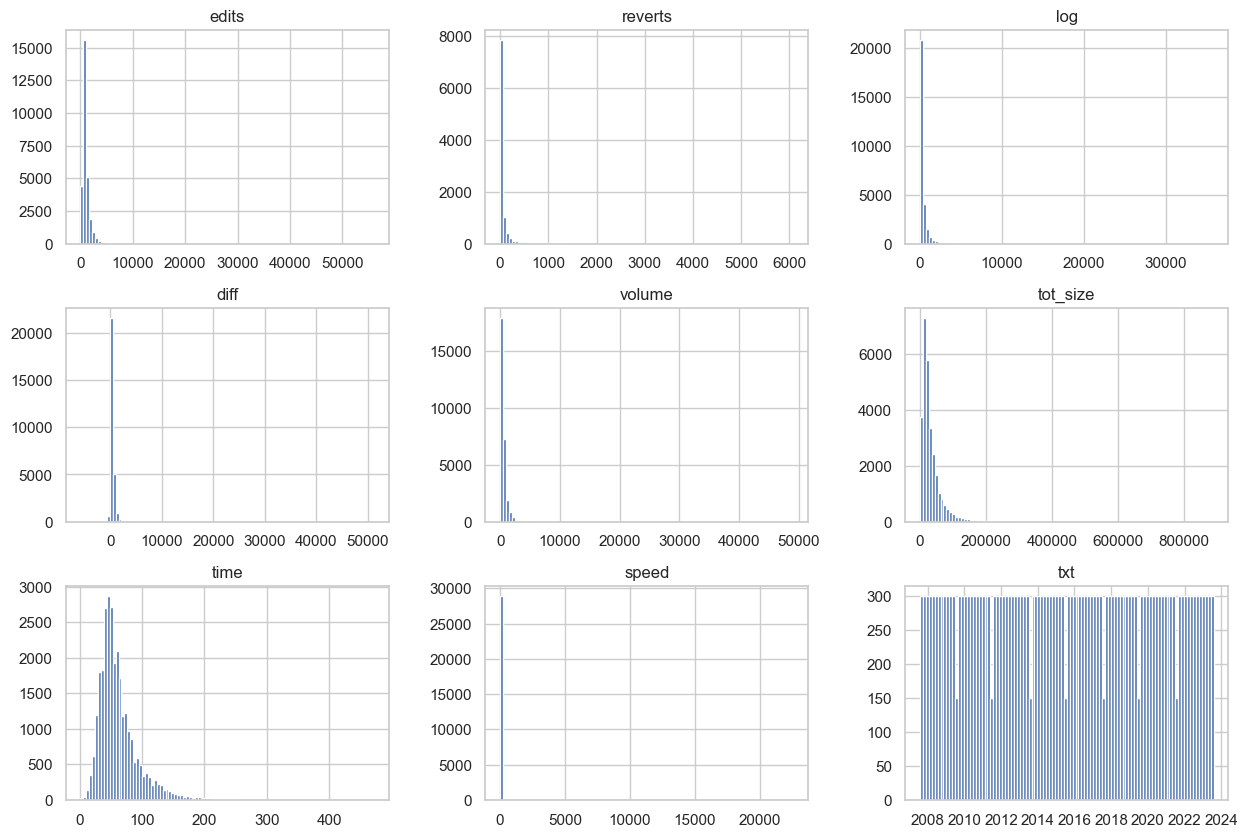

In [71]:
stats.hist(figsize=(15, 10), bins=100);

**Столбец еdits**
    
- показывает нам количество правок, отрицательных значений судя по распределению там нет. Есть данные, которые можно считать аномалиями. Посмотрим с помощью boxplot() и метода quantile() сколько значений-выбросов находится за верхней и нижней границами распределения. Зададим функцию для расчета верхней и нижней границы для значений-выбросов, т.к. для каждого набора данных они будут разными.

In [72]:
def lower_upper(df):
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    return lower_bound, upper_bound 

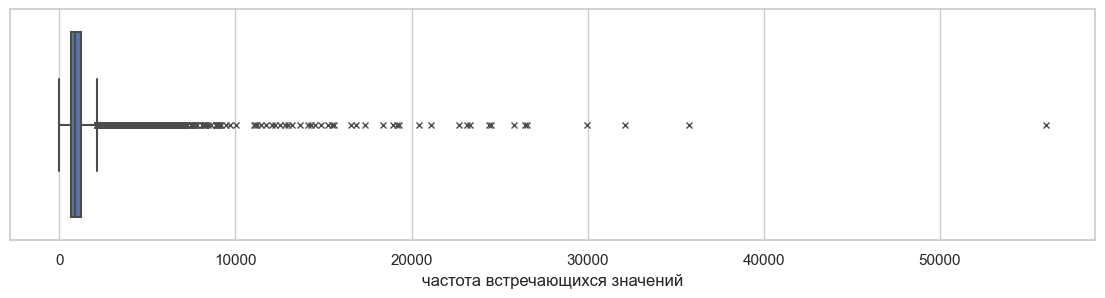

In [73]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
bp = sns.boxplot(x=stats['edits'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [74]:
lower_bound, upper_bound  = lower_upper(stats['edits'])
print(len(stats[(stats['edits'] < lower_bound) | (stats['edits'] > upper_bound)]), ' строк со значениями-выбросами')

2170  строк со значениями-выбросами


Возможно наилучшее решение по поводу данных аномальных значений это удаление. Проведем аналогичные изыскания по остальным столбцам и оценим общий объем значений-выбросов прежде, чем принимать решение об их удалении.

In [75]:
remove_list = stats[(stats['edits'] < lower_bound) | (stats['edits'] > upper_bound)]
stats_cor = stats.drop(labels=remove_list.index).reset_index(drop=True)

**Столбец reverts**
    
- Здесь отражено количество отмен чужих правок, отрицательных значений судя по распределению тут нет. Посмотрим сколько значений можно считать выбросами.

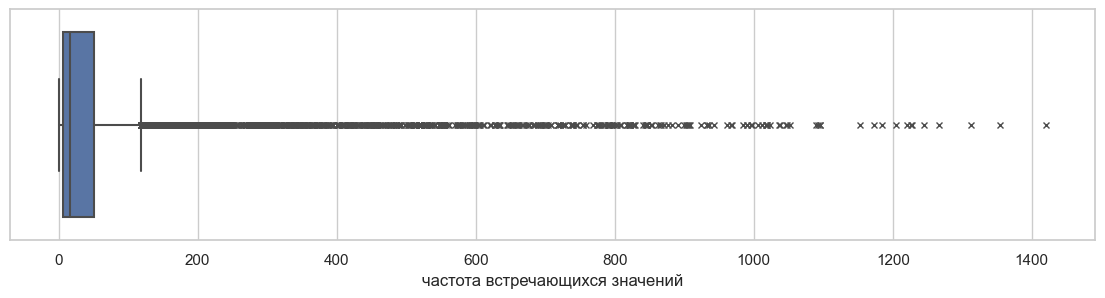

In [76]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
sns.boxplot(x=stats_cor['reverts'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [77]:
lower_bound, upper_bound  = lower_upper(stats_cor['reverts'])
print(len(stats_cor[(stats_cor['reverts'] < lower_bound) | (stats_cor['reverts'] > upper_bound)]), ' строк со значениями-выбросами')

1106  строк со значениями-выбросами


Возможно наилучшее решение по поводу данных аномальных значений это удаление, т.к. их количество невелико относительно общего количества данных.

In [78]:
remove_list_reverts = stats_cor[(stats_cor['reverts'] < lower_bound) | (stats_cor['reverts'] > upper_bound)].index
stats_cor = stats_cor.drop(index=remove_list_reverts).reset_index(drop=True)

**Столбец log**

- Здесь отражено количество иных действий, отличных от отмен чужих правок, отрицательных значений судя по распределению тут нет.

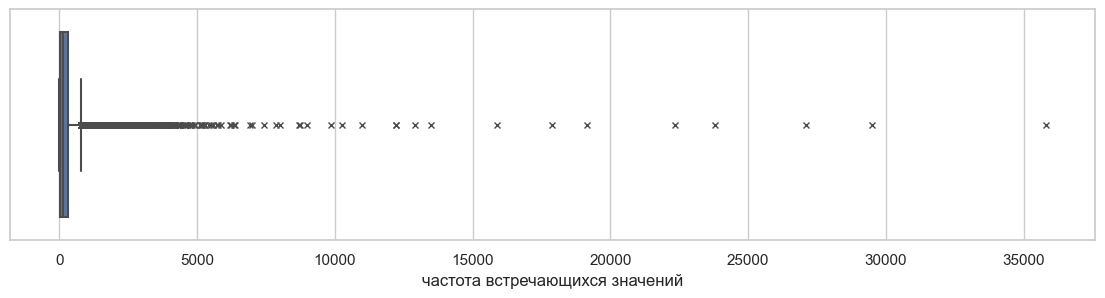

In [79]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
sns.boxplot(x=stats_cor['log'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [80]:
lower_bound, upper_bound  = lower_upper(stats_cor['log'])
print(len(stats_cor[(stats_cor['log'] < lower_bound) | (stats_cor['log'] > upper_bound)]), ' строк со значениями-выбросами')

2194  строк со значениями-выбросами


Поступим аналогично - удаляем.

In [81]:
remove_list_log = stats_cor[(stats_cor['log'] < lower_bound) | (stats_cor['log'] > upper_bound)].index
stats_cor = stats_cor.drop(index=remove_list_log).reset_index(drop=True)

**Столбец diff**

- Зде указана разница в объеме добавленной и удаленной информации, таким образом отрицательные значения тут - норма, значит надо проверить нет ли слишком больших отрицательных или положительных значений.

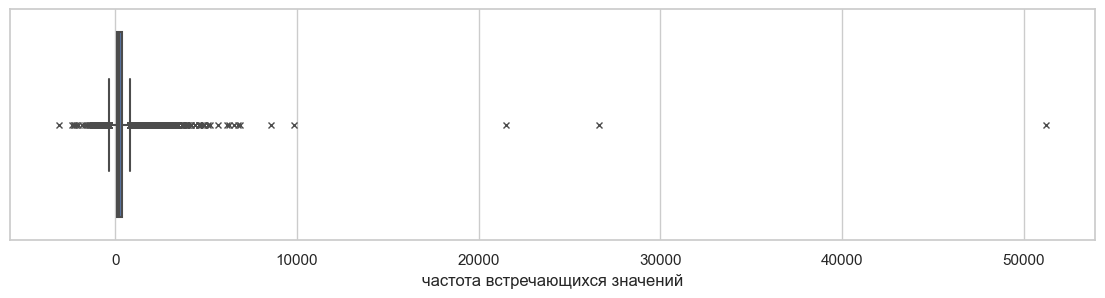

In [82]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
sns.boxplot(x=stats_cor['diff'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [83]:
lower_bound, upper_bound  = lower_upper(stats_cor['diff'])
print(len(stats_cor[(stats_cor['diff'] < lower_bound) | (stats_cor['diff'] > upper_bound)]), ' строк со значениями-выбросами')

1570  строк со значениями-выбросами


Поступаем аналогично - удаляем.

In [84]:
remove_list_diff = stats_cor[(stats_cor['diff'] < lower_bound) | (stats_cor['diff'] > upper_bound)].index
stats_cor = stats_cor.drop(index=remove_list_diff).reset_index(drop=True)

**Столбец volume**
    
- Здесь отражен общий объем добавленной информации на момент правки, отрицательных значений судя по распределению тут нет. Посмотрим сколько значений-выбросов.

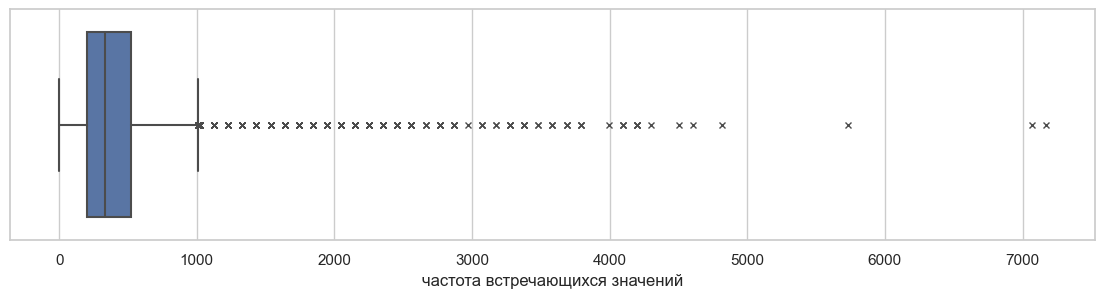

In [85]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
sns.boxplot(x=stats_cor['volume'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [86]:
lower_bound, upper_bound  = lower_upper(stats_cor['volume'])
print(len(stats_cor[(stats_cor['volume'] < lower_bound) | (stats_cor['volume'] > upper_bound)]), ' строк со значениями-выбросами')

783  строк со значениями-выбросами


Поступаем аналогично - удаляем.

In [87]:
remove_list_volume = stats_cor[(stats_cor['volume'] < lower_bound) | (stats_cor['volume'] > upper_bound)].index
stats_cor = stats_cor.drop(index=remove_list_volume).reset_index(drop=True)

**Столбец tot_size**
    
- Здесь отражен общий накопленный объем добавленной информации на момент правки, отрицательных значений судя по распределению тут нет. Посмотрим сколько значений-выбросов.

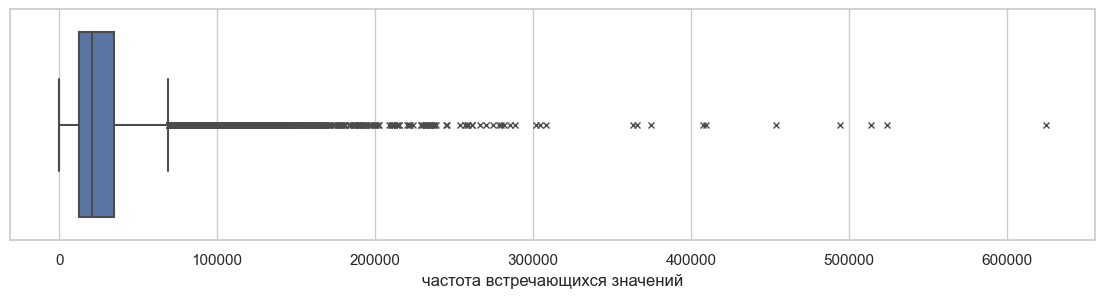

In [88]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
sns.boxplot(x=stats_cor['tot_size'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [89]:
lower_bound, upper_bound  = lower_upper(stats_cor['tot_size'])
print(len(stats_cor[(stats_cor['tot_size'] < lower_bound) | (stats_cor['tot_size'] > upper_bound)]), ' строк со значениями-выбросами')

1366  строк со значениями-выбросами


Поступаем аналогично - удаляем.

In [90]:
remove_list_tot_size = stats_cor[(stats_cor['tot_size'] < lower_bound) | (stats_cor['tot_size'] > upper_bound)].index
stats_cor = stats_cor.drop(index=remove_list_tot_size).reset_index(drop=True)

**Столбец time**
    
- Здесь отражена информация о времени, проведенном пользователем онлайн, отрицательных значений судя по распределению тут нет. Посмотрим сколько  значений-выбросов.

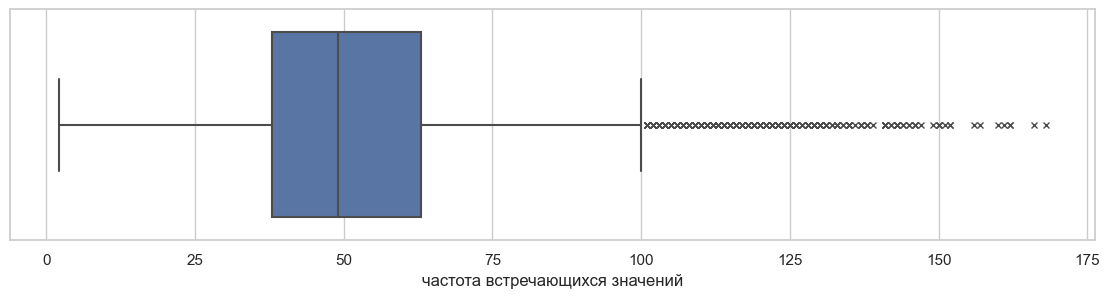

In [91]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
sns.boxplot(x=stats_cor['time'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [92]:
lower_bound, upper_bound  = lower_upper(stats_cor['time'])
print(len(stats_cor[(stats_cor['time'] < lower_bound) | (stats_cor['time'] > upper_bound)]), ' строк со значениями-выбросами')

535  строк со значениями-выбросами


Поступаем аналогично - удаляем.

In [93]:
remove_list_time = stats_cor[(stats_cor['time'] < lower_bound) | (stats_cor['time'] > upper_bound)].index
stats_cor = stats_cor.drop(index=remove_list_time).reset_index(drop=True)

**Столбец speed**
    
- Здесь отражена скорость, с которой пользователь вносил информацию (мы перевели ранее данные в количество правок в час), отрицательных значений судя по распределению тут нет. Посмотрим сколько значений-выбросов.

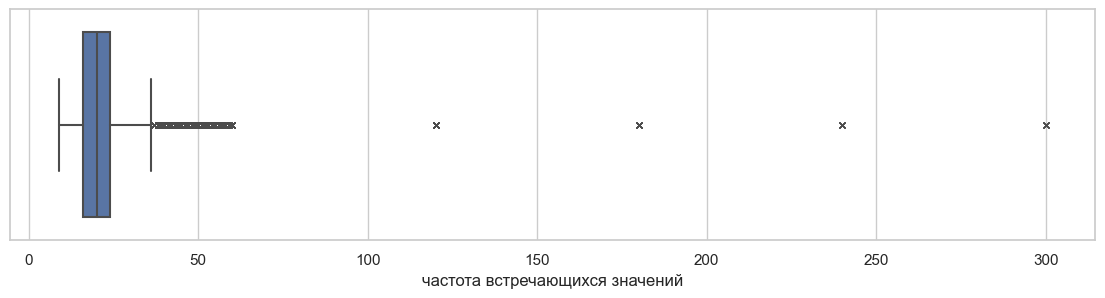

In [94]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 3))
sns.boxplot(x=stats_cor['speed'], flierprops={"marker": "x"})
ax.set(ylabel="", xlabel="частота встречающихся значений");

In [95]:
lower_bound, upper_bound  = lower_upper(stats_cor['speed'])
print(len(stats_cor[(stats_cor['speed'] < lower_bound) | (stats_cor['speed'] > upper_bound)]), ' строк со значениями-выбросами')

932  строк со значениями-выбросами


Поступаем аналогично - удаляем.

In [96]:
remove_list_speed = stats_cor[(stats_cor['speed'] < lower_bound) | (stats_cor['speed'] > upper_bound)].index
stats_cor = stats_cor.drop(index=remove_list_speed).reset_index(drop=True)

**Оценим общий объем удаленной информации при предоработке.**

In [97]:
print((1 - len(stats_cor)/ len(stats))*100)

36.80829015544042


Удалению подверглается почти 37% датасета, что не допустимо, т.к. мы могли потерять статистически значимую часть данных.

Наиболее вероятно, что разброс данных связан с наличием в датасете информаиции о различных категориях пользователей, так называемое мультимодальное распределение, таким образом рассматривать датасет на выбросы в совокупном размере не корректно.

Теперь проверим датасет votes  на  аномалии по аналогичной "программе".

#### Датасет votes

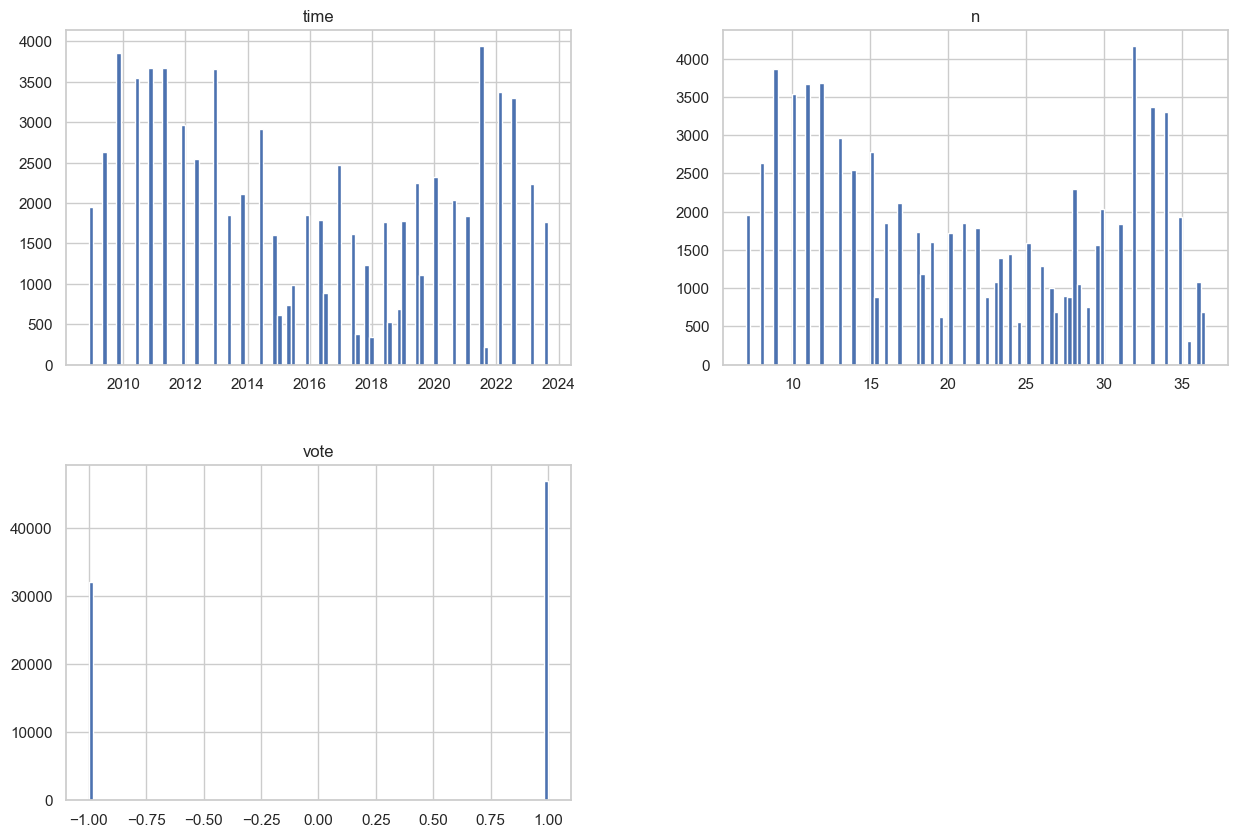

In [98]:
votes.hist(figsize=(15, 10), bins=100);

На первый взгляд с данными всё в порядке, ранее мы отмечали высокое качество подготовки данного датасета. Предлагается закончить на данном этапе предобработку данных и приступить к исследовательскому анализу.

## Исследовательский анализ данных

### Интерес авторов к платформе Wikipedia

Учитывая отсутствие точной информации о значении данных в столбцах log,	diff, volume и tot_size, попробуем проанализировать датасет stats на предмет интереса со стороны новых пользователей, используя минимальную дату в стобце txt.

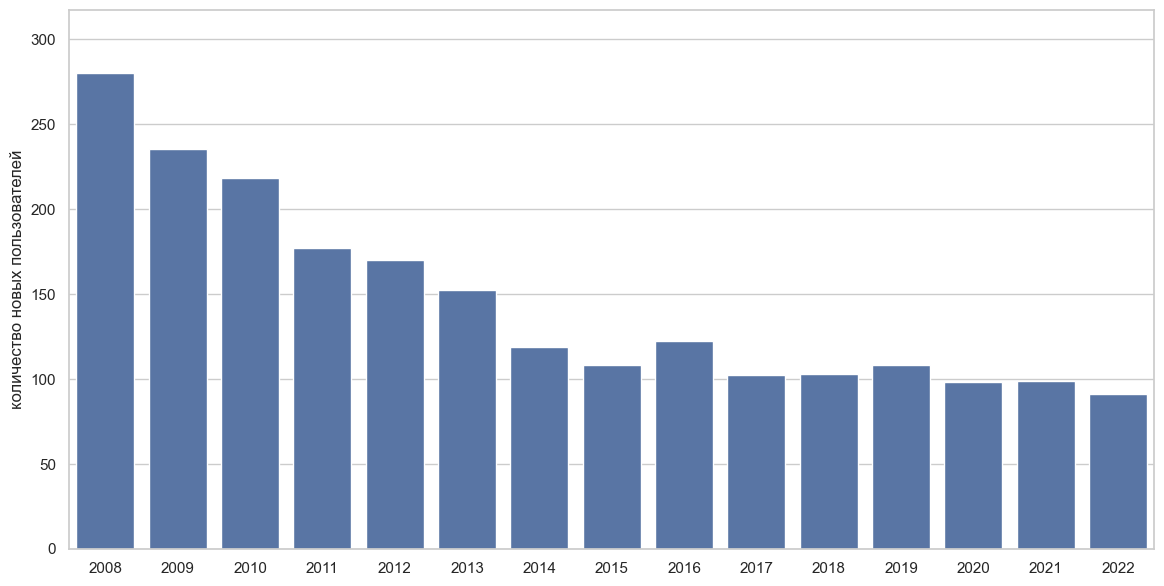

In [99]:
interest = stats.groupby('user')['txt'].min().reset_index() # группируем по пользователю, находим первую дату (месяц)
interest.columns = ['user', 'first_date']
monthly_interest = interest.groupby('first_date')['user'].count().reset_index() # группируем по первой дате, находим месячное количество пользователей
monthly_interest['year'] = pd.DatetimeIndex(monthly_interest['first_date']).year # выделяем год из даты
year_interest = monthly_interest.groupby('year')['user'].sum().reset_index() # группируем по году и находим годовое "пополнение" рядов
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x="year", y="user", data=year_interest, color="b")
ax.set(xlim=(0.5, 15.5), ylabel="количество новых пользователей", xlabel="");

Предположим, что в 2007 году какое-то количество пользователей уже числилось в рядах авторов и они не проявляли активность в течение всего 2007 года, поэтому 2007 год можно исключить, также исключим 2023 год, т.к. данные неполные.

На диаграмме тенденция к снижению интереса к платформе со стороны авторов за последние 15 лет. Вероятно это обусловлено достижением какого-то определенного уровня наполненности контента, для которого достаточно иметь опеределенный по размеру авторский состав.

Посмотрим на распределение авторов по продолжительности их активности (своебразный lifetime).

In [100]:
# сделаем сводную таблицу для определения суммарного количества правок по автору и первой/последней даты по автору
life_time = stats.pivot_table(index='user', values={'txt', 'edits'}, aggfunc={'edits': "sum", 'txt': ["min", "max"]})
life_time = life_time.reset_index()
life_time.columns = ['user', 'edits', 'max', 'min']
# добавим столбец с периодом активности автора
life_time['time'] = (life_time['max'] - life_time['min']).dt.days
life_time = life_time.drop(labels=['user', 'max', 'min'], axis=1)
# сгруппируем данные по продолжительности активности, чтобы посчитать сколько 
# авторов были активны с какой продолжительностью и сколько сделали правок
data_life = life_time.groupby('time')['edits'].agg(['count', 'sum']).reset_index()
# сегментируем авторов по периодам - неделя, 2 недели, месяц, полгода, 6-12 месяцев и более года
df = []
for i in data_life['time']:
    if i <= 7:
        df.append('week')
    elif i > 7 and i <=14:
        df.append('2 weeks')
    elif i > 14 and i <= 31:
        df.append('month')
    elif i > 31 and i <= 180:
        df.append('6 month')
    elif i > 180 and i <= 365:
        df.append('6-12 month')
    else:
        df.append('> year')

data_life['group'] = df
data_life.groupby('group')['count', 'sum'].sum() # группируем авторов по сегментам

,count,sum
group,,
6 month,255,705719
6-12 month,239,1254374
> year,1097,29217002
month,186,306977
week,764,604654


Построим круговые диаграммы для наглядного отражения полученных результатов.

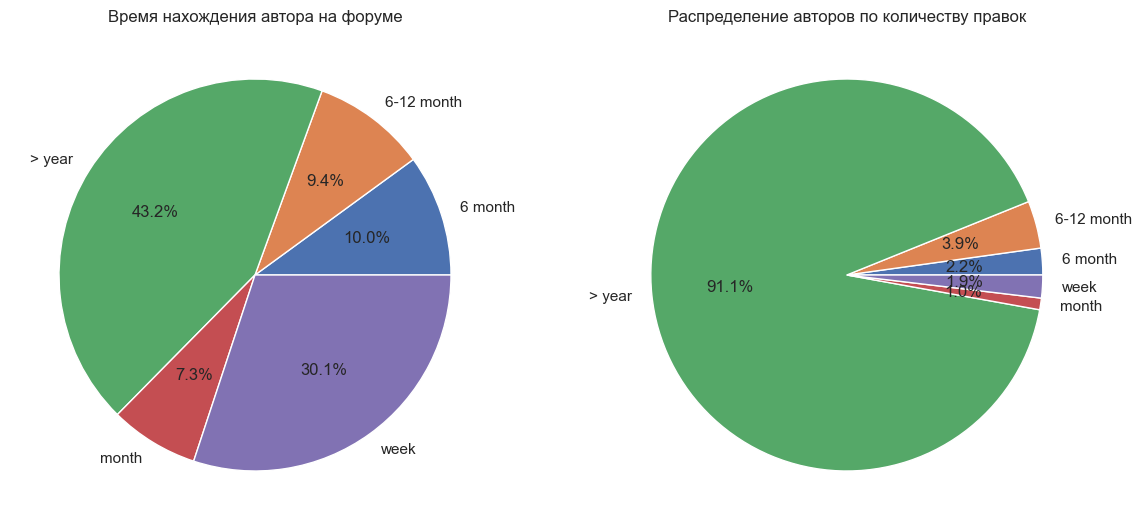

In [101]:
users_segment = data_life.groupby('group')['count', 'sum'].sum() # группируем данные для построения круговых диаграмм 

plt.figure(figsize=(14, 14))

ax1 = plt.subplot(2, 2, 1)
ax1.pie(users_segment['count'], labels=users_segment.index, autopct='%1.1f%%')
plt.title('Время нахождения автора на форуме')

ax2 = plt.subplot(2, 2, 2)
ax2.pie(users_segment['sum'], labels=users_segment.index, autopct='%1.1f%%')
plt.title('Распределение авторов по количеству правок');

Получается, что только 43% авторов остаются активными на платфоррме в течение более года, при этом аж 30% заканчивают свою активность в первую же неделю. 90 % всех сделанных правок приходится на авторов-долгожителей.

Попробуем посмотреть сколько в среднем времени проходит между публикациями.

In [102]:
sorted_stats = stats.sort_values(by=['user', 'txt']) # отсортируем датасет по пользователям и датам, чтобы далее обработать последовательность дат

In [103]:
sorted_stats['delta_txt'] = sorted_stats['txt'].diff().dt.days # вычисляем разницу между значения столбца с датой в днях
mark = [] # создаем пустой список для маркирования границ между авторами в списке, 
          # т.к. разница дат при переходе от автора к автору будет нам ни к чему
items = sorted_stats['user']
# циклом проходимся по значениям столбца user чтобы отмаркировать переходы от автора к автору
for a, b in zip(items, items[1:]):
    if a == b:
        mark.append(0)
    else:
        mark.append(1)
sorted_stats = sorted_stats.drop(labels=25261).reset_index()
sorted_stats['user_mark'] = mark
sorted_stats.head(10)

,index,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt,delta_txt,user_mark
0,27062,1060,339.0,12.0,476.0,542.0,58368.0,34.0,31,-kgoodluck-,2022-08-01,NaN,0
1,27932,1006,746.0,158.0,571.0,693.0,33792.0,41.0,28,-kgoodluck-,2023-02-01,184.0,0
2,28570,735,525.0,5.0,223.0,320.0,29696.0,29.0,25,-kgoodluck-,2023-06-01,120.0,1
3,8979,822,NaN,3.0,120.0,139.0,8396.8,35.0,23,0lesja Sh,2012-07-01,-3987.0,1
4,16492,620,NaN,31.0,48.0,66.0,17408.0,43.0,15,0x0F,2016-09-01,1523.0,1
5,17343,841,NaN,10.0,193.0,210.0,10240.0,82.0,10,1.b2-b4,2017-03-01,181.0,0
6,17439,1437,NaN,15.0,341.0,431.0,16384.0,133.0,11,1.b2-b4,2017-04-01,31.0,0
7,17628,980,NaN,21.0,-63.0,698.0,16384.0,89.0,11,1.b2-b4,2017-05-01,30.0,0
8,17824,740,NaN,13.0,-455.0,762.0,13312.0,65.0,11,1.b2-b4,2017-06-01,31.0,1
9,5826,787,NaN,160.0,379.0,425.0,10035.2,40.0,23,102RB,2010-10-01,-2435.0,1


In [104]:
sorted_stats = sorted_stats.query('user_mark == 0') # убираем строки, для которых мы отметили границу перехода
# считаем среднее время между публикациями для пользователей
users_delta = (
                sorted_stats.pivot_table(
                                        index='user',
                                        values={'edits', 'delta_txt', 'reverts', 'speed'},
                                        aggfunc='median')
                .reset_index()
)
users_delta.columns = ['user', 'median_delta_txt', 'median_edits_sum', 'median_reverts', 'median_speed']
users_delta['median_delta_txt'].median()

31.0

Среднее время между публикациями у пользователей составляет 31 день. Посмотрим на зависимость между интервалом между публикациями и средним количеством правок, вносимых авторами (с учетом средней величины отмен чужих правок).

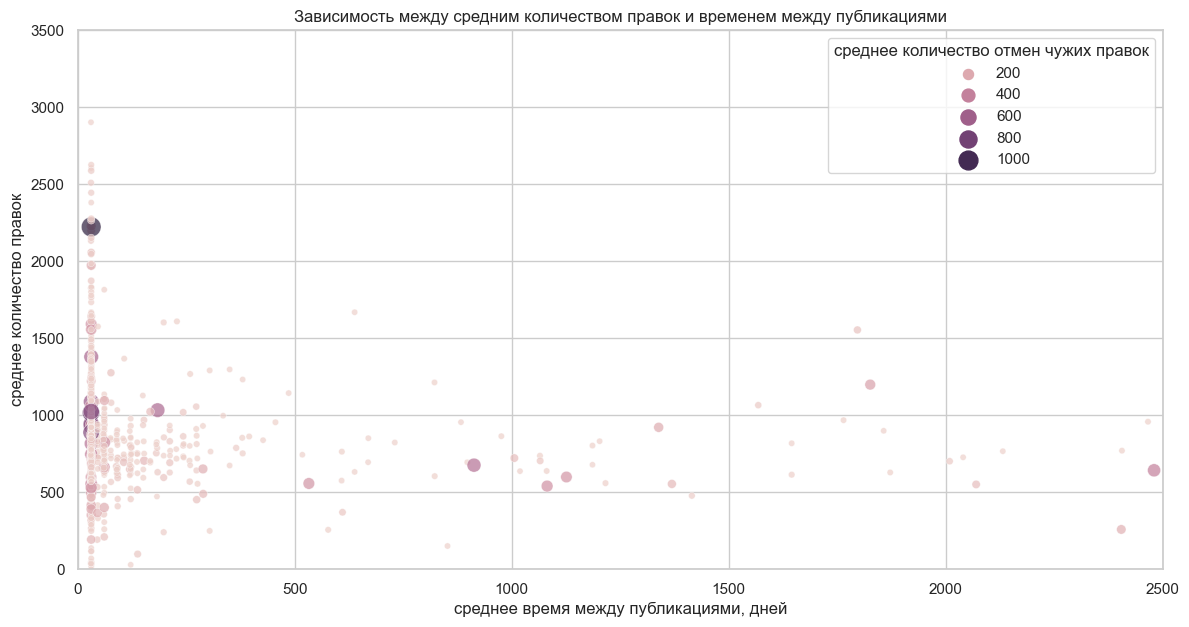

In [105]:
plt.figure(figsize=(14, 7))
g = (
    sns.scatterplot(
    x="median_delta_txt", 
    y="median_edits_sum",
    hue='median_reverts',
    size="median_reverts",
    sizes=(20, 200),
    alpha=.7,
    data=users_delta)
)
g.set(xlim=(0, 2500), ylim=(0, 3500), ylabel = 'среднее количество правок', xlabel='среднее время между публикациями, дней')
g.set(title='Зависимость между средним количеством правок и временем между публикациями')
g.legend(title='среднее количество отмен чужих правок');

Получается в целом ожидаемая картина - чем меньше период между публикациями, тем большее количество правок и отмен чужих правок. Интересная деталь заключается в том, что отмены чужих правок встречаются либо там, где среднее время между публикациями небольшое, либо наоборот значительное. Авторы, которые публикуют что-то с периодичностью 400-1000 дней почти не имеют отмен чужих правок, возможно это говорит о типах личности авторов, которые более сдержанно и взвешанно относятся к чужому мнению, нежели авторы публикующиеся очень часто или наоборот очень редко. 

**Подитожим выводы по датасету stats:**
- Прослеживается тенденция к снижению интереса к платформе со стороны авторов за последние 15 лет. Вероятно это обусловлено достижением какого-то определенного уровня наполненности контента, для которого достаточно иметь опеределенный по размеру авторский состав.
- Только 43% авторов остаются активными на платфоррме в течение более года, при этом аж 30% заканчивают свою активность в первую же неделю. Почти 90% всех сделанных правок приходится на авторов-долгожителей.
- Среднее время между публикациями у пользователей составляет 31 день.
- Чем меньше период между публикациями, тем большее количество правок и отмен чужих правок. Авторы, которые публикуют что-то с периодичностью 400-1000 дней почти не имеют отмен чужих правок.

### Анализ процедуры голосования за авторов по датасету votes

Итак, исходя из полученных пояснений выборы проводятся каждые полгода. Побеждают кандидаты, которые набирают ⅔ голосов “за”.
Выбирают комиссию (ареопаг), которая обладает особыми правами. Например решать споры о банах/разбанах пользователей или статей.

Сперва проанализируем периоды проведения выборов, количество голосующих и кандидатов. Для этого добавим столбцы с датой и временем начала выборов, годом и месяцем выборов.

In [106]:
votes['voting_start'] = votes['time'] - votes['lt']
votes['voting_start_year'] = pd.DatetimeIndex(votes['voting_start']).year
votes['voting_start_month'] = pd.DatetimeIndex(votes['voting_start']).month

Сформируем сводную таблицу, объединяющую выборные процессы.

In [107]:
voting_dinamics = (
                    votes.pivot_table(index={'voting_start_year', 'voting_start_month'},
                                      values={'voting_start', 'voter', 'candidate', 'time', 'n'},
                                      aggfunc={'voting_start': 'min', 'voter': 'nunique', 'candidate': 'nunique', 'time': 'max', 'n': 'mean'})
                         .reset_index()
)
voting_dinamics.columns = ['month', 'year', 'candidates', 'n', 'voting_end', 'voters', 'voting_start']
voting_dinamics['voting_time'] = voting_dinamics['voting_end'] - voting_dinamics['voting_start']
voting_dinamics.head(15)

,month,year,candidates,n,voting_end,voters,voting_start,voting_time
0,1,2013,7,15.500000,2013-01-09 00:59:00,195,2013-01-02,7 days 00:59:00
1,1,2019,5,27.750000,2019-01-15 23:55:00,244,2019-01-09,6 days 23:55:00
2,1,2020,16,29.338584,2020-02-06 00:06:00,262,2020-01-06,31 days 00:06:00
3,1,2021,13,31.000000,2021-02-05 23:56:00,250,2021-01-30,6 days 23:56:00
4,1,2022,17,33.000000,2022-02-05 23:59:00,341,2022-01-30,6 days 23:59:00
5,1,2023,11,35.000000,2023-02-06 04:18:00,249,2023-01-30,7 days 04:18:00
6,2,2023,2,35.500000,2023-03-02 19:02:00,187,2023-02-24,6 days 19:02:00
7,5,2009,16,8.000000,2009-05-30 23:17:00,315,2009-05-24,6 days 23:17:00
8,5,2010,19,10.000000,2010-05-29 23:59:00,347,2010-05-23,6 days 23:59:00
9,5,2011,17,12.000000,2011-05-28 23:47:00,359,2011-05-22,6 days 23:47:00


Как мы видим выборы проходят не только каждые полгода, помимо 5го и 11го месяцев встречаются также и 1,  6, 12,  7,  2,  8. Исходя из значений в столбце n - это довыборы.

In [108]:
voting_dinamics['month'].unique()

array([ 1,  2,  5,  6,  7,  8, 11, 12], dtype=int64)

Выборы и довыборы в среднем длятся 7 дней.

In [109]:
voting_dinamics['voting_time'].median()

Timedelta('6 days 23:56:00')

Количество кандидатов и голосующих постоянно разное. Посмотрим сколько членов ареопага выбирается на выборах. 

In [110]:
votings_ = (
            votes.query('vote > 0')
            .pivot_table(index={'voting_start_year', 'voting_start_month', 'candidate'}, values='vote', aggfunc='sum').reset_index()
)
votings = votes.pivot_table(index={'voting_start_year', 'voting_start_month', 'candidate'}, values='vote', aggfunc='count').reset_index()
votings['votes_for'] = votings_['vote']
votings['votes_for%'] = (votings['votes_for'] / votings['vote']) * 100
elected = []
for i in votings['votes_for%']:
    if i >= (2/3)*100:
        elected.append('elected')
    else:
        elected.append('not elected')
votings['elected'] = elected
votings.query('elected == "elected"').pivot_table(index='voting_start_month', columns='voting_start_year', values='elected', aggfunc='count')

voting_start_year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
voting_start_month,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,7.0,7.0,6.0,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,NaN,8.0,7.0,5.0,5.0,6.0,4.0,6.0,3.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,6.0,7.0,7.0,5.0,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
11,6.0,6.0,5.0,5.0,4.0,5.0,4.0,8.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN


Из сформированной таблицы можно сделать вывод о том, что в состав ареопага выбирается не менее 5 членов, когда критериям соответствует меньшее количество кандидатов, назначаются довыборы. Также видно, что в 2019 году произошли изменения в процедуре выборов (начали проходить в январе и июле).

Посмотрим на состав ареопагов, выбираемых по результатам выборов/довыборов.

In [111]:
pd.set_option('display.max_colwidth', None)
votings.query('elected == "elected"').groupby(['voting_start_year', 'voting_start_month'])['candidate'].unique().reset_index()

,voting_start_year,voting_start_month,candidate
0,2008,11,"[Chronicler, EvgenyGenkin, Ilya Voyager, Kaganer, Kv75, Александр Сигачёв]"
1,2009,5,"[Carn, DR, Levg, Testus, Victoria, Wind, Yaroslav Blanter, Сайга]"
2,2009,11,"[Blacklake, Claymore, Dmitry Rozhkov, Ilya Voyager, NBS, Фил Вечеровский]"
3,2010,5,"[Artem Korzhimanov, Daryona, David.s.kats, Testus, Track13, Vladimir Solovjev, Yaroslav Blanter]"
4,2010,11,"[Altes, Dmitry Rozhkov, Dodonov, Levg, Vlsergey]"
5,2011,5,"[Artem Korzhimanov, D.bratchuk, Vladimir Solovjev, Сайга, Фил Вечеровский]"
6,2011,11,"[D.bratchuk, Drbug, INSAR, Levg, ShinePhantom]"
7,2012,5,"[DR, Generous, Michgrig, Vladimir Solovjev, Vlsergey]"
8,2012,11,"[Altes, Biathlon, Melirius, Wind]"
9,2013,1,"[Drbug, Lazyhawk]"


Состав ареопагов достаточно разношерстный от года к году. Составим Топ-10 наиболее успешных кандидатов, которые выбирались наибольшее количество раз.

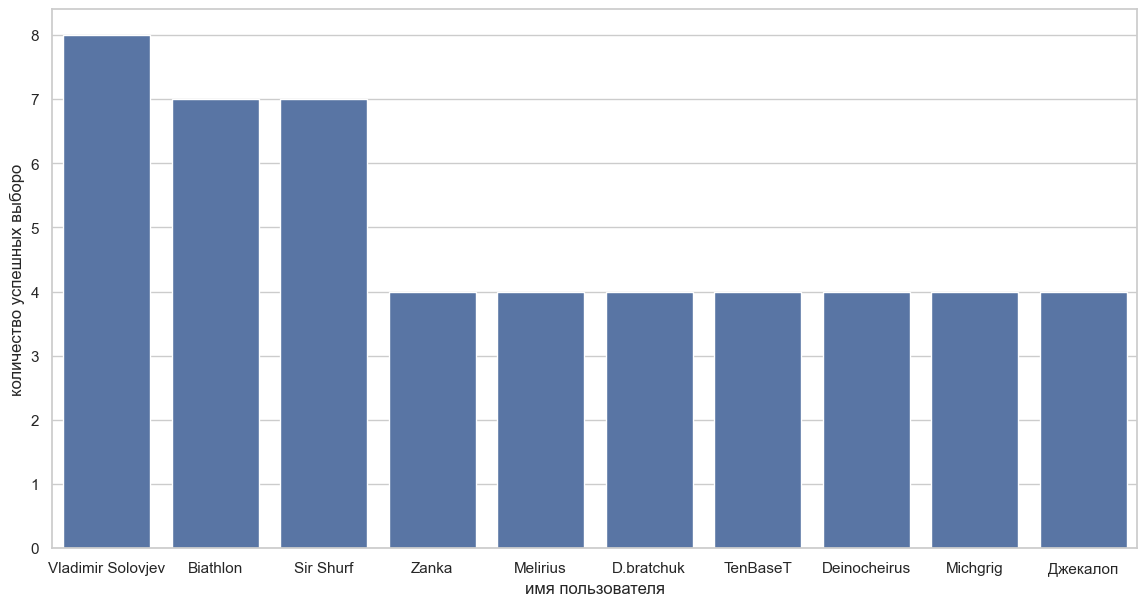

In [112]:
top_candidates = (
    votings.query('elected == "elected"')
    .groupby('candidate')['voting_start_year']
    .agg(['count', 'unique'])
    .sort_values(by='count', ascending=False).reset_index()
    .head(10)
)
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x="candidate", y="count", data=top_candidates, color="b")
ax.set(ylabel="количество успешных выборо", xlabel="имя пользователя");

Не тот ли это Владимир Соловьев....? Впрочем фамилия и имя достаточно распространенное.

Здесь нужно сделать поправку, что в одном календарном году человек мог избираться дважды, поэтому уникальные наименования годов не всегда соответствуют посчитанному количеству.

Теперь перейдем к голосующим и попробуем проанализировать динамику голосований. Посмотрим как динамика голосований распределена по дням голосования.

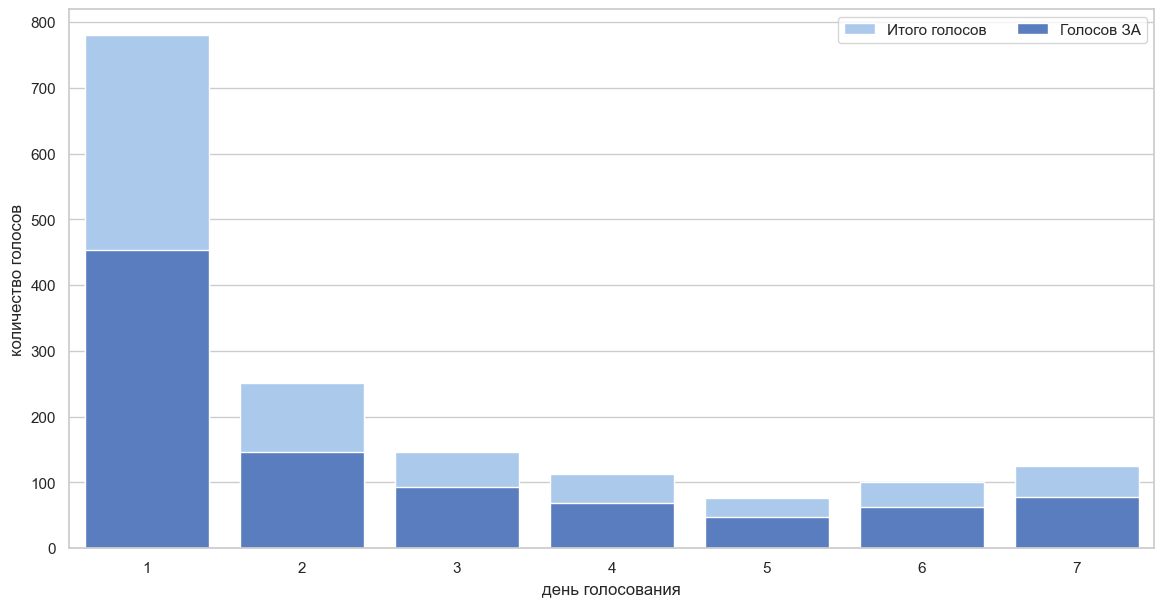

In [113]:
votes['day'] = votes['lt'].dt.days + 1
election_dinamics = votes.query('day != 8').pivot_table(index='voting_start', values = 'vote', columns='day', aggfunc='count').median().reset_index()
sns.set_theme(style="whitegrid")
election_dinamics_for = (
                        votes.query('day != 8 & vote > 0')
                        .pivot_table(index='voting_start', values = 'vote', columns='day', aggfunc='count')
                        .median().reset_index()
)
election_dinamics['for'] = election_dinamics_for[0]
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 7))
sns.set_color_codes("pastel")
sns.barplot(x="day", y=0, data=election_dinamics, label="Итого голосов", color="b")
sns.set_color_codes("muted")
sns.barplot(x="day", y="for", data=election_dinamics, label="Голосов ЗА", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="количество голосов", xlabel="день голосования");

Основная масса голосов отдается в первый день голосования, несмотря на то, что выборы растянуты на неделю. Интерес к голосованию снижается к пятому дню и потом обычно увеличивается, вероятно это связано с желанием непроголосовавших отдать свои голоса за кандидатов. Распределение голосов за по дням голосования существенно не отличается.

Интересно посмотреть как динамика голосования зависит от дня недели.

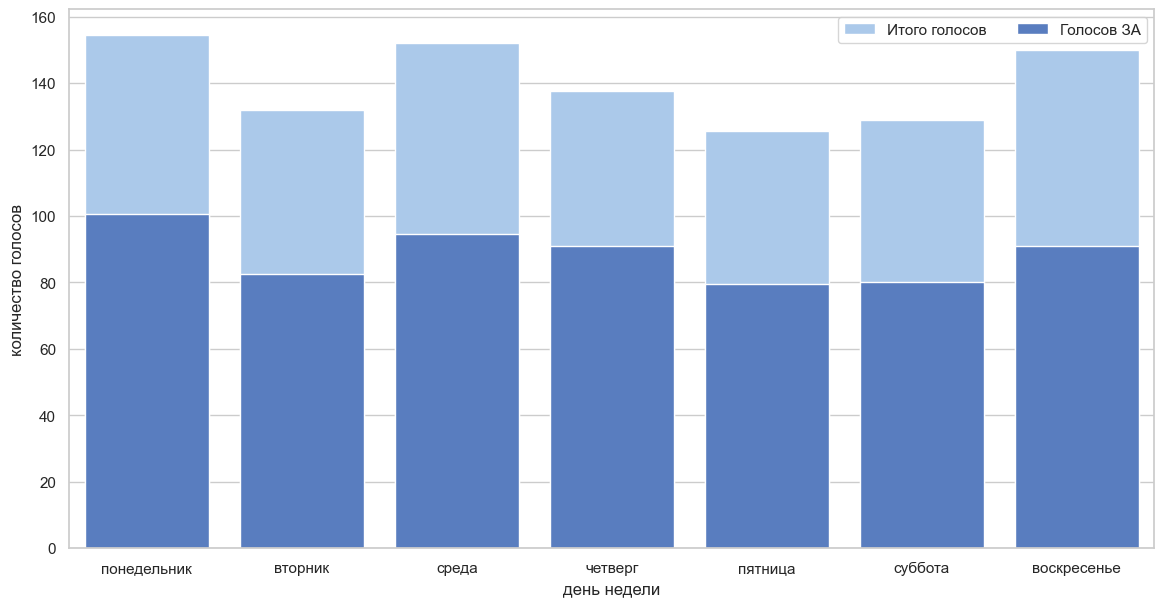

In [114]:
day_of_week = []
for i in votes['time']:
    day_of_week.append(i.day_of_week)
votes['day_of_week'] = day_of_week
election_dinamics_week = (
                            votes.query('day != 8')
                            .pivot_table(index='voting_start', values = 'vote', columns='day_of_week', aggfunc='count')
                            .median().reset_index()
)
sns.set_theme(style="whitegrid")
election_dinamics_week_for = (
                        votes.query('day != 8 & vote > 0')
                        .pivot_table(index='voting_start', values = 'vote', columns='day_of_week', aggfunc='count')
                        .median().reset_index()
)
election_dinamics_week['for'] = election_dinamics_week_for[0]
election_dinamics_week['day_of_week'] = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 7))
sns.set_color_codes("pastel")
sns.barplot(x="day_of_week", y=0, data=election_dinamics_week, label="Итого голосов", color="b")
sns.set_color_codes("muted")
sns.barplot(x="day_of_week", y="for", data=election_dinamics_week, label="Голосов ЗА", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="количество голосов", xlabel="день недели");

В понедельник, среду и воскресенье активность голосования выше, чем в остальные дни, однако существенных различий не видно. Рспределение голосов за от дня недели тоже существенно не зависит.

Посмотрим как голоса распределяются по времени дня голосования (первая половина дня, вторая половина дня).

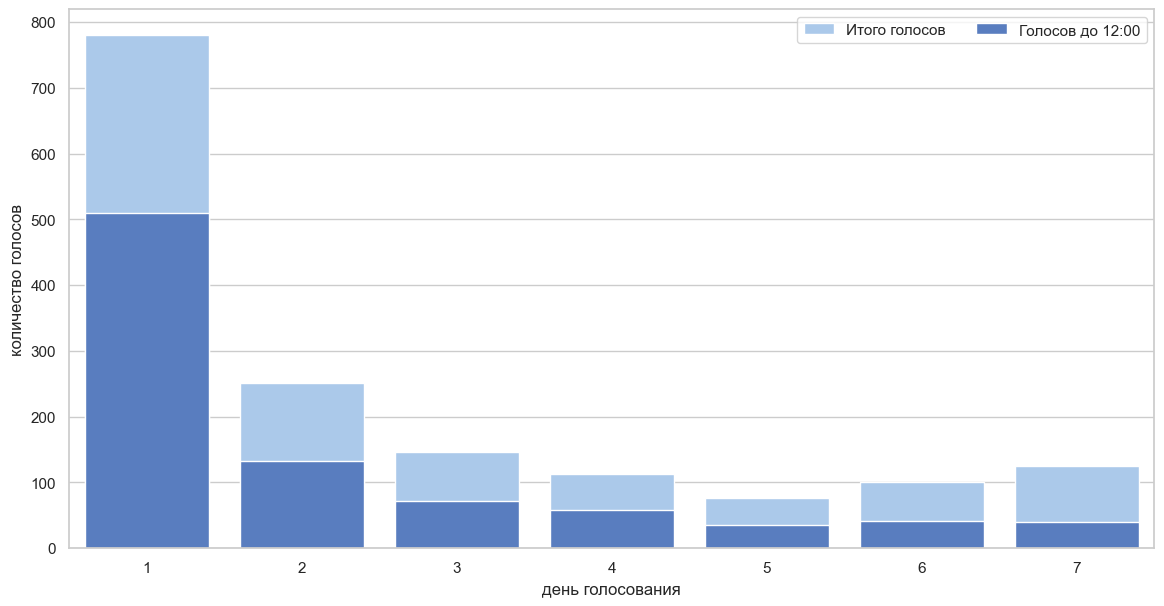

In [115]:
votes['hour'] = pd.DatetimeIndex(votes['time']).hour
am_pm = []
for i in votes['hour'] :
    if i <= 12:
        am_pm.append('am')
    else:
        am_pm.append('pm')
votes['am_pm'] = am_pm
election_dinamics_am = (
                        votes.query('day != 8 & am_pm == "am"')
                        .pivot_table(index='voting_start', values = 'vote', columns='day', aggfunc='count')
                        .median().reset_index()
)
election_dinamics['am'] = election_dinamics_am[0]
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 7))
sns.set_color_codes("pastel")
sns.barplot(x="day", y=0, data=election_dinamics, label="Итого голосов", color="b")
sns.set_color_codes("muted")
sns.barplot(x="day", y="am", data=election_dinamics, label="Голосов до 12:00", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="количество голосов", xlabel="день голосования");

В первый день голосования люди голосуют в основном в первой половине дня, далее распределение сравнивается, после чего в последние 2 дня голосования основная масса голосов смещается в сторону второй половины дня. Посмотрим как подобное распределение выглядит по дням недели.

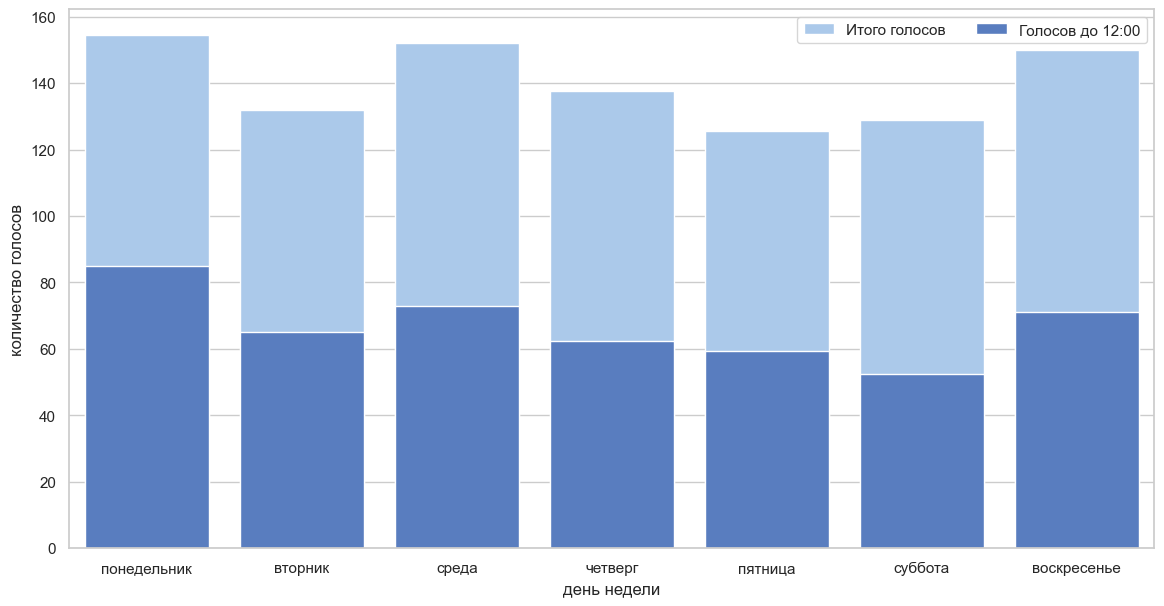

In [116]:
sns.set_theme(style="whitegrid")
election_dinamics_week_am = (
                        votes.query('day != 8 & am_pm == "am"')
                        .pivot_table(index='voting_start', values = 'vote', columns='day_of_week', aggfunc='count')
                        .median().reset_index()
)
election_dinamics_week['am'] = election_dinamics_week_am[0]
election_dinamics_week['day_of_week'] = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 7))
sns.set_color_codes("pastel")
sns.barplot(x="day_of_week", y=0, data=election_dinamics_week, label="Итого голосов", color="b")
sns.set_color_codes("muted")
sns.barplot(x="day_of_week", y="am", data=election_dinamics_week, label="Голосов до 12:00", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="количество голосов", xlabel="день недели");

Большее количество голосов по дням недели отдается во второй половине дня, в особенности в выходные дни. В первые 3 дня данное распределение почти 50:50, в понедельник с перевесом в сторону утра.

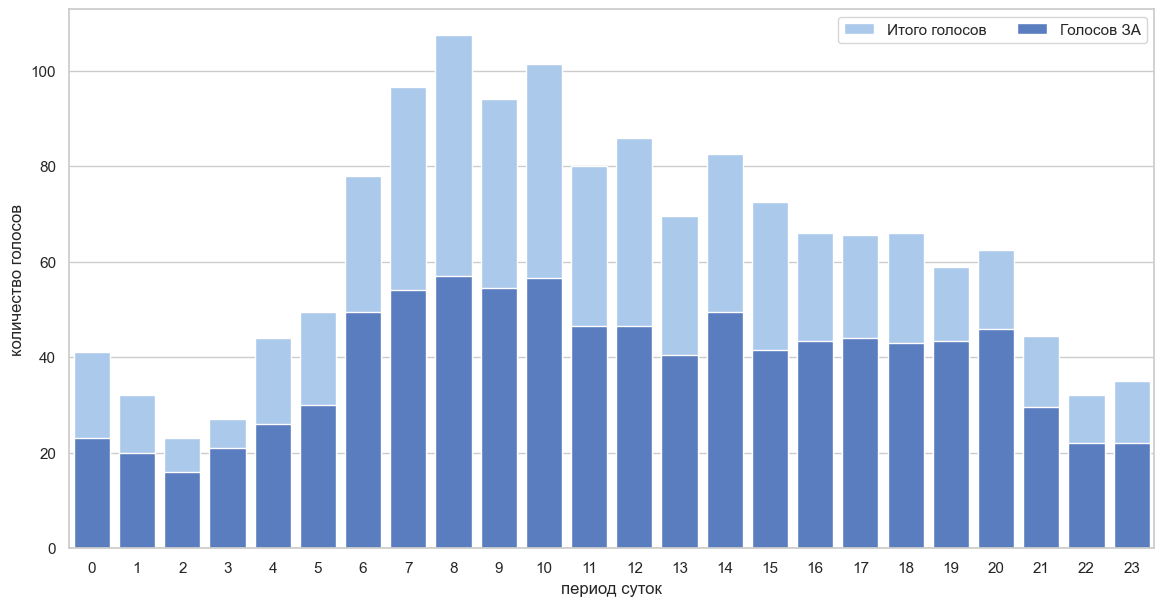

In [117]:
election_dinamics_hours = (
                        votes.query('day != 8')
                        .pivot_table(index='voting_start', values = 'vote', columns='hour', aggfunc='count')
                        .median().reset_index()
)
election_dinamics_hours_for = (
                        votes.query('day != 8 & vote > 0')
                        .pivot_table(index='voting_start', values = 'vote', columns='hour', aggfunc='count')
                        .median().reset_index()
)
election_dinamics_hours['for'] = election_dinamics_hours_for[0] 
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 7))
sns.set_color_codes("pastel")
sns.barplot(x="hour", y=0, data=election_dinamics_hours, label="Итого голосов", color="b")
sns.set_color_codes("muted")
sns.barplot(x="hour", y="for", data=election_dinamics_hours, label="Голосов ЗА", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="количество голосов", xlabel="период суток");

Наибольшая интенсивность голосования наблюдается в период с 6:00 до 20:00. Минимальная активность с 21:00 до 5:00 включительно. При этом голосов "ЗА" ночью отдается преимущественно больше, чем в дневные часы, что может указывать на более критический подход к голосованию в дневные часы. Наибольшая активность избирателей, а также их более критический настрой наблюдается в период с 7:00 до 10:00. 

**Подитожим выводы по датасету votes**

- состав ареопагов различный от года к году, учитывая, что процедура выборов демократичная. В топ-3 наиболее успешных кандидатов попали пользователи:
    - Vladimir Solovjev	 - 8 раз,
    - Biathlon - 7 раз,
    - Sir Shurf - 7 раз.

- основная масса избирателей голосует в первый день голосования, интерес к голосованию снижается к пятому дню и потом немного увеличивается, вероятно это связано с желанием непроголосовавших отдать свои голоса за кандидатов.
- в понедельник, среду и воскресенье активность голосования выше, чем в остальные дни.
- в первый день голосования люди голосуют в основном в первой половине дня, далее распределение сравнивается, после чего в последние 2 дня голосования основная масса голосов смещается в сторону второй половины дня.
- большее количество голосов по дням недели (с понедельника по воскресенье) отдается во второй половине дня, в особенности в выходные дни.
- наибольшая интенсивность голосования наблюдается в период с 6:00 до 20:00, при этом наибольная активность и их более критический настрой наблюдается в период с 7:00 до 10:00.
- минимальная активность избирателей и их большая лояльность наблюдается с 21:00 до 3:00 включительно.

## Выводы по результатам исследования

1. В данной работе проведена подготовка "сырых" данных для дальнейшего анализа в том числе откорректированы форматы, устранены пропуски, обнаружены и устранены аномалии, проведена проверка на дубликаты и т.д.
2. После предподготовки двух датасетов с данными проанализирована активность пользователей по датасету stats, построены визуализации.
3. Далее исследована голосующяю аудитория проекта, выделены сегмент, пострены визуализации.
4. По результатам исследования можно отметить основные выводы
   
   - за последние 15 лет прослеживается тенденция к снижению интереса к платформе Wikipedia со стороны авторов, вероятно это вполне "органический" процесс, обусловленный наполненняемостью контентом, для которого достаточно иметь опеределенный по размеру авторский состав, т.к. количество тем для публикаций становится всё меньше, качество контента повышается и не нуждается в большом количестве исправлений.
   - только 43% авторов остаются активными на платфоррме в течение более года, при этом аж 30% заканчивают свою активность в первую же неделю.
   - 91% всех сделанных правок приходится на авторов-долгожителей (активные более года), среднее время между публикациями у пользователей составляет 31 день.
   - чем меньше период между публикациями, тем большее количество правок и отмен чужих правок.
   - основная масса избирателей голосует за кандидатов в ареопаг в первый день голосования, интерес к голосованию далее снижается день ото дня в последние два дня наблюдается небольшой всплеск активности что может быть связано с "подключением" тех избирателей, которые привыкли оставлять подобные дела на потом.
   - в понедельник, среду и воскресенье активность голосования выше, чем в остальные дни.
   - наибольшая активность со стороны избирателей наблюдается в период с 6:00 до 20:00, максимальная активность и их более критический настрой наблюдается в период с 7:00 до 10:00.
   - минимальная активность избирателей и их большая лояльность наблюдается с 21:00 до 3:00 включительно.